In [28]:
import xarray as xr
import glob
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm import tqdm
import matplotlib.pyplot as plt

import vis

In [29]:
# Determine the device to use
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("Using CPU device")

Using CPU device


In [30]:
# Loading and combining datasets
path = "./data"
nc_files = glob.glob(os.path.join(path, "*.nc4"))
nc_files = [fname for fname in nc_files if ('2015' not in fname)]
combined_ds = xr.open_mfdataset(nc_files, combine='nested', 
                                parallel=True, concat_dim='Time')
combined_ds

<xarray.Dataset> Size: 2GB
Dimensions:       (Time: 1461, lat: 256, lon: 256)
Coordinates:
    lat           (lat, lon) float32 262kB 38.44 38.44 38.44 ... 41.02 41.03
    lon           (lat, lon) float32 262kB 253.5 253.5 253.5 ... 256.3 256.3
Dimensions without coordinates: Time
Data variables:
    FRC_URB2D     (Time, lat, lon) float32 383MB dask.array<chunksize=(1, 256, 256), meta=np.ndarray>
    URB_CAT       (Time, lat, lon) float32 383MB dask.array<chunksize=(1, 256, 256), meta=np.ndarray>
    q2            (Time, lat, lon) float32 383MB dask.array<chunksize=(1, 256, 256), meta=np.ndarray>
    t2_raw        (Time, lat, lon) float32 383MB dask.array<chunksize=(1, 256, 256), meta=np.ndarray>
    tb_urb2d      (Time, lat, lon) float32 383MB dask.array<chunksize=(1, 256, 256), meta=np.ndarray>
    tb_urb2d_max  (Time, lat, lon) float32 383MB dask.array<chunksize=(1, 256, 256), meta=np.ndarray>
Attributes: (12/50)
    SIMULATION_START_DATE:           0000-00-00_00:00:00
    WEST-EAST_GRID_DIMENSION:        4609
    SOUTH-NORTH_GRID_DIMENSION:      3841
    BOTTOM-TOP_GRID_DIMENSION:       0
    WEST-EAST_PATCH_START_UNSTAG:    1
    WEST-EAST_PATCH_END_UNSTAG:      4608
    ...                              ...
    FLAG_LAI12M:                     1
    FLAG_LAKE_DEPTH:                 1
    nco_openmp_thread_number:        1
    NCO:                             netCDF Operators version 5.1.9 (Homepage...
    TITLE:                           OUTPUT FROM GEOGRID V4.0.1
    history:                         Mon Feb 26 12:28:49 2024: ncks -4 -L 1 c...

In [5]:
# Defining the config and hyperparameters
config = {
    'batch_size': 8,
    'num_epochs':20,
    'learning_rate': 1e-4,
    'test_size': 0.2,
}

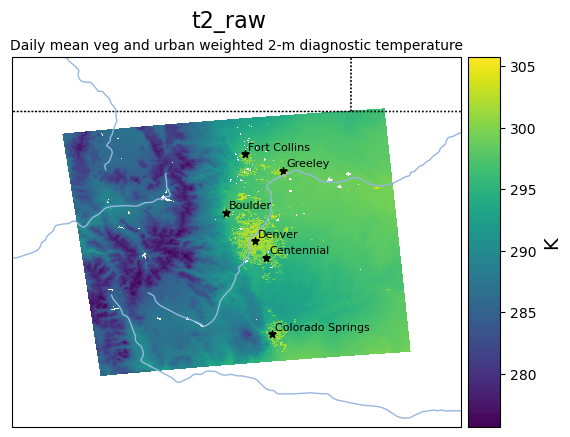

In [6]:
var = 't2_raw'
sliced_var = combined_ds[var]
vis.plot_var(sliced_var, contour=False)

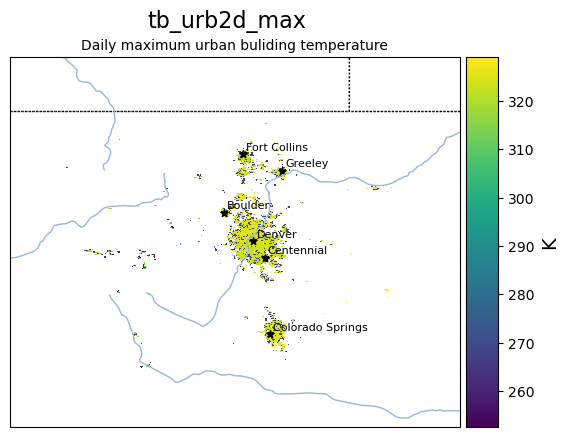

In [7]:
var = 'tb_urb2d_max'
sliced_var = combined_ds[var]
vis.plot_var(sliced_var, contour=False)

In [31]:
# Fill nan values with 0s for all variables
t2_raw = combined_ds.t2_raw
# mean_t2 = t2_raw.mean(dim='Time', skipna=True)
# std_t2 = t2_raw.std(dim='Time', skipna=True)
# standardized_t2 = (t2_raw - mean_t2) / std_t2
# filled_t2_raw = standardized_t2.fillna(0)
filled_t2_raw = t2_raw.fillna(0)
expanded_t2 = np.expand_dims(filled_t2_raw, axis=1)

q2 = combined_ds.q2
# mean_q2 = q2.mean(dim='Time', skipna=True)
# std_q2 = q2.std(dim='Time', skipna=True)
# standardized_q2 = (q2 - mean_q2) / std_q2
# filled_q2 = standardized_q2.fillna(0)
filled_q2 = q2.fillna(0)
expanded_q2 = np.expand_dims(filled_q2, axis=1)

tb_urb2d = combined_ds.tb_urb2d
# mean_tb_urb2d = tb_urb2d.mean(dim='Time', skipna=True)
# std_tb_urb2d = tb_urb2d.std(dim='Time', skipna=True)
# standardized_tb_urb2d = (tb_urb2d - mean_tb_urb2d) / std_tb_urb2d
# filled_tb_urb2d = standardized_tb_urb2d.fillna(0)
filled_tb_urb2d = tb_urb2d.fillna(0)
expanded_tb_urb2d = np.expand_dims(filled_tb_urb2d, axis=1)

tb_urb2d_max = combined_ds.tb_urb2d_max
# mean_tb_urb2d_max = tb_urb2d_max.mean(dim='Time', skipna=True)
# std_tb_urb2d_max = tb_urb2d_max.std(dim='Time', skipna=True)
# standardized_tb_urb2d_max = (tb_urb2d_max - mean_tb_urb2d_max) / std_tb_urb2d_max
# filled_tb_urb2d_max = standardized_tb_urb2d_max.fillna(0)
filled_tb_urb2d_max = tb_urb2d_max.fillna(0)
expanded_tb_urb2d_max = np.expand_dims(filled_tb_urb2d_max, axis=1)

FRC_URB2D = combined_ds.FRC_URB2D
filled_FRC_URB2D = FRC_URB2D.fillna(0)
expanded_FRC_URB2D = np.expand_dims(filled_FRC_URB2D, axis=1)

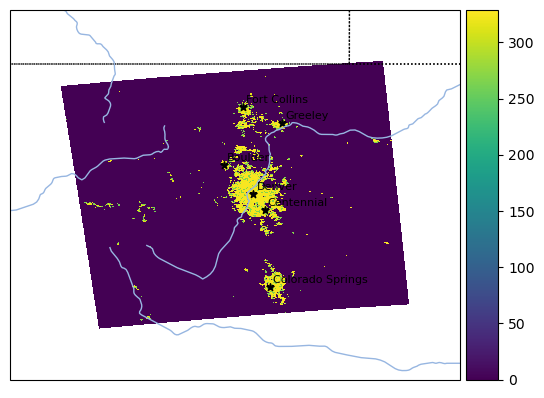

In [10]:
var = 'tb_urb2d_max'
sliced_var = combined_ds[var]
vis.plot_var_numpy(expanded_tb_urb2d_max[0,0,:,:], combined_ds, contour=False)

In [32]:
# Create a dataset to serve the data
class TimeSeriesDataset(Dataset):
    def __init__(self, data1, data2, data3, time_step=1):
        self.time_step = time_step
        self.data1 = data1
        self.data2 = data2
        self.data3 = data3

    def __len__(self):
        return len(self.data1) - self.time_step

    def __getitem__(self, idx):
        return np.concatenate((self.data1[idx,:,:,:], self.data2[idx,:,:,:]), axis=0), self.data3[idx+self.time_step]

dataset = TimeSeriesDataset(expanded_t2, expanded_q2, expanded_tb_urb2d_max)

In [33]:
# Split into test and train datasets
test_size = int(len(dataset) * config['test_size'])
train_size = len(dataset) - test_size 

indices = np.arange(len(dataset))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, drop_last=True)

In [34]:
class CNNTimeSeriesForecast(nn.Module):
    def __init__(self, input_size, mlp_expand_size=4):
        super(CNNTimeSeriesForecast, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_size[0], 16, kernel_size=(3,3), stride=2, padding=(1, 1)),
            # nn.Conv2d(input_size[0], 16, kernel_size=(3,3), stride=1, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(3,3), stride=2, padding=(1,1)),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=2, padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.flattened_size = self._get_flattened_size(input_size)

        self.conv_transpose3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_transpose2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_transpose1 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.activation = nn.ReLU()

    def _get_flattened_size(self, input_size):
        dummy_input = torch.zeros(2, *input_size)
        with torch.no_grad():
            x = self.conv1(dummy_input)
            x = self.conv2(x)
            x = self.conv3(x)
        return x.view(x.size(0), -1).size(1)
    
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)

        x_batch, x_channel, x_height, x_width = x3.shape
        x = x3.view(x3.size(0), -1)
        x = x.reshape(x_batch, x_channel, x_height, x_width)

        x = x + x3
        x = self.activation(self.conv_transpose3(x))
        x = x + x2  
        x = self.activation(self.conv_transpose2(x))
        x = x + x1  
        x = self.conv_transpose1(x)

        return x

dummy_input= next(iter(test_loader))[0].to(device)
model = CNNTimeSeriesForecast(input_size=dummy_input[0].shape, mlp_expand_size=1).to(device)

model(dummy_input).shape

torch.Size([8, 1, 256, 256])

In [14]:
# # Create a mask over the non-null values
# non_null_mask = combined_ds.t2_raw.notnull()
# collapsed_mask = np.all(non_null_mask.values, axis=0)

# mask_shape = collapsed_mask.shape
# x_dim = mask_shape[0]
# y_dim = mask_shape[1]

# target_size = max(x_dim, y_dim)
# if target_size % 8 != 0:
#     target_size = ((target_size // 8) + 1) * 8

# x_padding = target_size - x_dim
# x_left_padding = x_padding // 2
# x_right_padding = x_padding - x_left_padding

# y_padding = target_size - y_dim
# y_left_padding = y_padding // 2
# y_right_padding = y_padding - y_left_padding

# padded_mask = np.pad(collapsed_mask, ((x_left_padding, x_right_padding), (y_left_padding, y_right_padding)), mode='constant', constant_values=0)

# expanded_mask = np.expand_dims(padded_mask, axis=0)

# batch_size = config['batch_size']
# batch_mask = np.repeat(expanded_mask[np.newaxis, :, :], batch_size, axis=0)

# mask_tensor_t2 = torch.from_numpy(batch_mask.astype(np.float32)).to(device)
# mask_tensor.shape

NameError: name 'mask_tensor' is not defined

In [84]:
# # Create a mask over the non-null values
# non_null_mask = combined_ds.q2.notnull()
# collapsed_mask = np.all(non_null_mask.values, axis=0)

# mask_shape = collapsed_mask.shape
# x_dim = mask_shape[0]
# y_dim = mask_shape[1]

# target_size = max(x_dim, y_dim)
# if target_size % 8 != 0:
#     target_size = ((target_size // 8) + 1) * 8

# x_padding = target_size - x_dim
# x_left_padding = x_padding // 2
# x_right_padding = x_padding - x_left_padding

# y_padding = target_size - y_dim
# y_left_padding = y_padding // 2
# y_right_padding = y_padding - y_left_padding

# padded_mask = np.pad(collapsed_mask, ((x_left_padding, x_right_padding), (y_left_padding, y_right_padding)), mode='constant', constant_values=0)

# expanded_mask = np.expand_dims(padded_mask, axis=0)

# batch_size = config['batch_size']
# batch_mask = np.repeat(expanded_mask[np.newaxis, :, :], batch_size, axis=0)

# mask_tensor_q2 = torch.from_numpy(batch_mask.astype(np.float32)).to(device)
# mask_tensor.shape

torch.Size([16, 1, 256, 256])

In [35]:
# Create a mask over the non-null values
non_null_mask = combined_ds.tb_urb2d_max.notnull()
collapsed_mask = np.all(non_null_mask.values, axis=0)

mask_shape = collapsed_mask.shape
x_dim = mask_shape[0]
y_dim = mask_shape[1]

target_size = max(x_dim, y_dim)
if target_size % 8 != 0:
    target_size = ((target_size // 8) + 1) * 8

x_padding = target_size - x_dim
x_left_padding = x_padding // 2
x_right_padding = x_padding - x_left_padding

y_padding = target_size - y_dim
y_left_padding = y_padding // 2
y_right_padding = y_padding - y_left_padding

padded_mask = np.pad(collapsed_mask, ((x_left_padding, x_right_padding), (y_left_padding, y_right_padding)), mode='constant', constant_values=0)

expanded_mask = np.expand_dims(padded_mask, axis=0)

batch_size = config['batch_size']
batch_mask = np.repeat(expanded_mask[np.newaxis, :, :], batch_size, axis=0)

mask_tensor_tb_urb2d_max = torch.from_numpy(batch_mask.astype(np.float32)).to(device)
mask_tensor_tb_urb2d_max.shape

torch.Size([8, 1, 256, 256])

In [36]:
# Training set up
criterion = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

In [ ]:
for epoch in range(config['num_epochs']):
    model.train()  
    train_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{config['num_epochs']-1}", leave=False)
    for features, labels in progress_bar:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(features)

        # Apply the mask to the outputs and labels
        masked_loss = criterion(outputs, labels) * mask_tensor_tb_urb2d_max
        loss = masked_loss.sum() / mask_tensor_tb_urb2d_max.sum()  # Normalize by the number of valid elements
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({'Train Loss': loss.item()})

    train_loss /= len(train_loader)

    model.eval()  
    test_loss = 0.0
    with torch.no_grad():  
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)

            # Apply the mask to the outputs and labels
            masked_loss = criterion(outputs, labels) * mask_tensor_tb_urb2d_max
            loss = masked_loss.sum() / mask_tensor_tb_urb2d_max.sum()  # Normalize by the number of valid elements
            test_loss += loss.item()

    test_loss /= len(test_loader)

    print(f"Epoch [{epoch}/{config['num_epochs']-1}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch [0/9], Train Loss: 87474.9326, Test Loss: 73838.9711


Epoch [1/9], Train Loss: 50744.7389, Test Loss: 34236.1551


Epoch [2/9], Train Loss: 27117.4405, Test Loss: 23763.8534


Epoch [3/9], Train Loss: 18420.5453, Test Loss: 15294.7699


Epoch [4/9], Train Loss: 12898.8523, Test Loss: 16316.4185


In [21]:
# Run the model on one example
features, labels = next(iter(test_loader))
features, labels = features.to(device), labels.to(device)

model.eval()
with torch.no_grad():
    outputs = model(features)

features = features.cpu().numpy()
labels = labels.cpu().numpy()
outputs = outputs.cpu().numpy()
mask = mask_tensor_tb_urb2d_max.cpu().numpy()

masked_output = outputs * mask

difference = labels - masked_output

<Figure size 2000x2000 with 0 Axes>

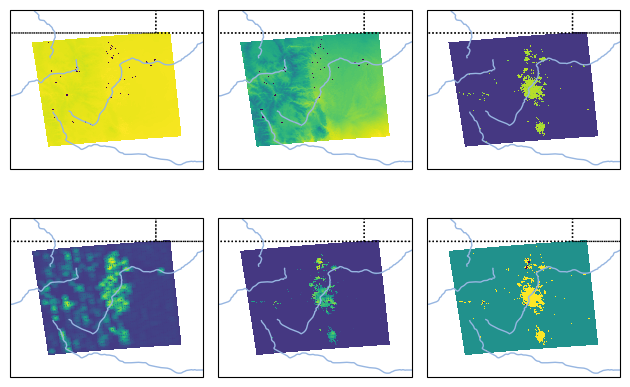

In [27]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Visualise the input and output data
sample_index = 1
vmin = min(features[sample_index].min(), labels[sample_index].min(), masked_output[sample_index].min(), difference[sample_index].min())
vmax = max(features[sample_index].max(), labels[sample_index].max(), masked_output[sample_index].max(), difference[sample_index].max())

# plt.figure(figsize=(15, 10))

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(20, 20))
fig, axs = plt.subplots(2, 3, sharey=True, subplot_kw={'projection': proj})

axs[0,0].coastlines()
axs[0,0].add_feature(cfeature.STATES, ls=':')
axs[0,0].add_feature(cfeature.RIVERS)
    
im = axs[0,0].pcolormesh(combined_ds.lon, combined_ds.lat, features[sample_index,0],
                         transform=ccrs.PlateCarree())
axs[0,0].set_extent([np.min(combined_ds.lon)-0.5, np.max(combined_ds.lon)+0.5,
                     np.min(combined_ds.lat)-0.5, np.max(combined_ds.lat)+0.5], crs=ccrs.PlateCarree())

axs[0,1].coastlines()
axs[0,1].add_feature(cfeature.STATES, ls=':')
axs[0,1].add_feature(cfeature.RIVERS)
im = axs[0,1].pcolormesh(combined_ds.lon, combined_ds.lat, features[sample_index,1],
                         transform=ccrs.PlateCarree())
axs[0,1].set_extent([np.min(combined_ds.lon)-0.5, np.max(combined_ds.lon)+0.5,
                     np.min(combined_ds.lat)-0.5, np.max(combined_ds.lat)+0.5], crs=ccrs.PlateCarree())

axs[0,2].coastlines()
axs[0,2].add_feature(cfeature.STATES, ls=':')
axs[0,2].add_feature(cfeature.RIVERS)
im = axs[0,2].pcolormesh(combined_ds.lon, combined_ds.lat, labels[sample_index,0], vmin=vmin, vmax=vmax,
                         transform=ccrs.PlateCarree())
axs[0,2].set_extent([np.min(combined_ds.lon)-0.5, np.max(combined_ds.lon)+0.5,
                     np.min(combined_ds.lat)-0.5, np.max(combined_ds.lat)+0.5], crs=ccrs.PlateCarree())

axs[1,0].coastlines()
axs[1,0].add_feature(cfeature.STATES, ls=':')
axs[1,0].add_feature(cfeature.RIVERS)
im = axs[1,0].pcolormesh(combined_ds.lon, combined_ds.lat, outputs[sample_index,0], vmin=vmin, vmax=vmax,
                         transform=ccrs.PlateCarree())
axs[1,0].set_extent([np.min(combined_ds.lon)-0.5, np.max(combined_ds.lon)+0.5,
                     np.min(combined_ds.lat)-0.5, np.max(combined_ds.lat)+0.5], crs=ccrs.PlateCarree())

axs[1,1].coastlines()
axs[1,1].add_feature(cfeature.STATES, ls=':')
axs[1,1].add_feature(cfeature.RIVERS)
im = axs[1,1].pcolormesh(combined_ds.lon, combined_ds.lat, masked_output[sample_index,0], vmin=vmin, vmax=vmax,
                         transform=ccrs.PlateCarree())
axs[1,1].set_extent([np.min(combined_ds.lon)-0.5, np.max(combined_ds.lon)+0.5,
                     np.min(combined_ds.lat)-0.5, np.max(combined_ds.lat)+0.5], crs=ccrs.PlateCarree())

axs[1,2].coastlines()
axs[1,2].add_feature(cfeature.STATES, ls=':')
axs[1,2].add_feature(cfeature.RIVERS)
im = axs[1,2].pcolormesh(combined_ds.lon, combined_ds.lat, 
                         labels[sample_index,0] - masked_output[sample_index,0],
                         transform=ccrs.PlateCarree(), vmin=-3.0, vmax=3.0)
axs[1,2].set_extent([np.min(combined_ds.lon)-0.5, np.max(combined_ds.lon)+0.5,
                     np.min(combined_ds.lat)-0.5, np.max(combined_ds.lat)+0.5], crs=ccrs.PlateCarree())

plt.tight_layout()

(8, 1, 256, 256)


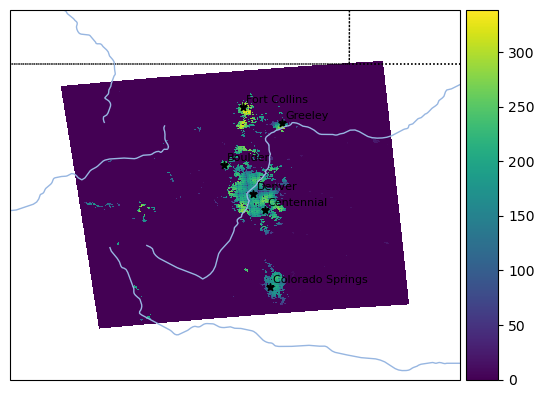

In [23]:
var = 'tb_urb2d_max'
sliced_var = combined_ds[var]
print(outputs.shape)
vis.plot_var_numpy(masked_output[sample_index,0,:,:], combined_ds, contour=False)

(8, 1, 256, 256)


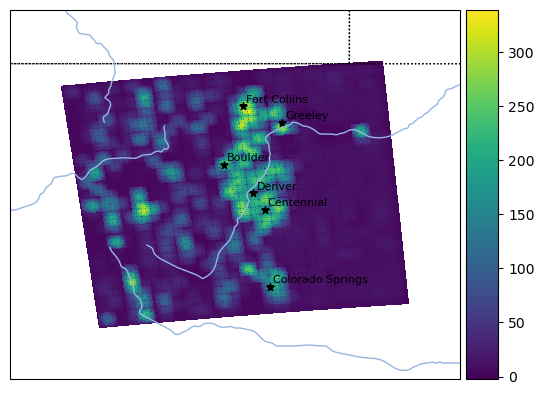

In [24]:
var = 'tb_urb2d_max'
sliced_var = combined_ds[var]
print(outputs.shape)
vis.plot_var_numpy(outputs[sample_index,0,:,:], combined_ds, contour=False)

(8, 1, 256, 256)


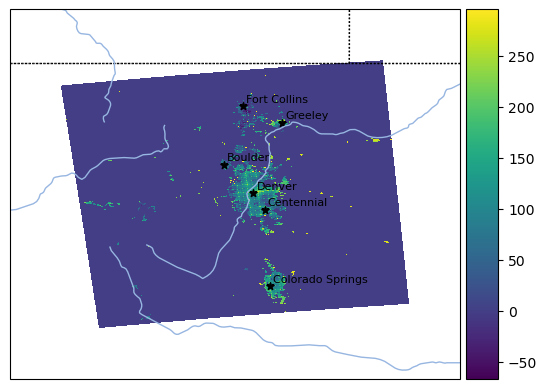

In [25]:
var = 'tb_urb2d_max'
sliced_var = combined_ds[var]
print(outputs.shape)
vis.plot_var_numpy(labels[sample_index,0] - masked_output[sample_index,0], combined_ds, contour=False)